# Evolutionary algorithm experiments

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import random
from typing import Tuple

from constants import PATH_PURE_COMPONENTS, PATH_MIXTURES, X
from file_io import load_pickle_file
from solvers.math import *
from solvers.correction_models import *

from numpy.random import normal

logging.basicConfig(level=logging.INFO)

In [3]:
logger = logging.getLogger(__name__)

## Load data

In [4]:
pure_components = load_pickle_file(PATH_PURE_COMPONENTS)
mixtures_data = load_pickle_file(PATH_MIXTURES)

## Analysis

### Constants

In [5]:
N_POPULATION = 200
N_SURVIVORS = 30
N_LINEAR_COMBINATIONS = 30
N_MUTATIONS = 100
INIT_GUESS = [0, 0, 0]
INIT_DEVIATIONS = [0.01, 0.1, 1]
N_MAX_GENERATIONS = 300
RSME_THRESHOLD = 2
N_STEADY_THRESHOLD = 50
MAX_X_DEVIATION = 50

In [6]:
correction_model = quadratic_correction
x_original = X
signal = mixtures_data[0]['signal']
true = mixtures_data[0]['contributions']

### Optimization

In [7]:
correction_model = quadratic_correction
n_population: int = 50
n_survivors: int = None
n_crossovers: int = None
n_mutations: int = None
init_guess: Tuple[float] = (0, 0, 0)
deviations: Tuple[float] = (0.01, 0.1, 1)
deviations_scaling: Tuple[float] = None
n_max_generations: int = 500
rsme_threshold: float = 1
n_no_change_threshold: int = 50
max_x_deviation: float = None
scaled_proportion = 0.7

In [8]:
all_rsme_values = []

In [9]:
# Initialize optional arguments if not given
if not max_x_deviation:
    max_x_deviation = (max(x_original) - min(x_original)) // 2
if not deviations_scaling:
    deviations_scaling = np.array([1 / k for k in range(1, n_max_generations + 1)])

# Initialize parameter candidates
parameters = []
for _ in range(n_population):
    candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(init_guess, deviations)]
    parameters.append(candidate)
parameters = np.array(parameters)

# Initialize optimization
min_rsme = float(np.inf)
return_solution, return_parameters = None, None
counter = 0

# Search for best parameter combination
for round in range(n_max_generations):
    counter += 1
    rsme_values = []

    for candidate in parameters:
        x_target = correction_model(x_original, candidate)

        # Check that interpolated x axis is within accepted range
        if abs(min(x_target) - min(x_original)) > max_x_deviation:
            rsme_values.append(float(np.inf))
            continue
        if abs(max(x_target) - max(x_original)) > max_x_deviation:
            rsme_values.append(float(np.inf))
            continue

        solution, residual = nnls_fit_with_interpolated_library(x_original, x_target, pure_components, signal)
        rsme_value = rsme(residual)
        rsme_values.append(rsme_value)

        # Update solution if RSME is smaller than current minimum
        if rsme_value < min_rsme:
            min_rsme = rsme_value
            return_solution = solution
            return_parameters = candidate
            counter = 0
            logger.info(f'Solution updated: Round {round}, RSME {min_rsme}')
    
    all_rsme_values.append(rsme_values)
    
    # Check termination conditions
    if min_rsme < rsme_threshold:
        logger.info(f'Target RSME reached. Iteration terminated at round {round}.')
        break
    if counter > n_no_change_threshold:
        logger.info(
            f"RSME didn't change in last {n_no_change_threshold} rounds. Iteration terminated at round {round}.")
        break
    if round == n_max_generations - 1:
        logger.warning(f"Maximum number of generations reached. Iteration terminated at round {round}.")
        break

    # Find best parameter combination
    index_lowest_rsme = np.argmin(rsme_values)
    best_parameters = parameters[index_lowest_rsme]

    # Generate new parameter combinations
    parameters = []
    parameters.append(best_parameters)
    scale = deviations_scaling[round]
    n_scaled = int(scaled_proportion * n_population)
    for _ in range(n_scaled):
        candidate = [normal(loc=mean, scale=scale * stdev) for mean, stdev in zip(best_parameters, deviations)]
        parameters.append(candidate)
    for _ in range(n_population - len(parameters)):
        candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(best_parameters, deviations)]
        parameters.append(candidate)
    parameters = np.array(parameters)

INFO:__main__:Solution updated: Round 0, RSME 186.91740716300512
INFO:__main__:Solution updated: Round 0, RSME 147.77012065707655
INFO:__main__:Solution updated: Round 0, RSME 31.48692285445077
INFO:__main__:Solution updated: Round 2, RSME 6.373865579021815
INFO:__main__:Solution updated: Round 6, RSME 3.686622812057095
INFO:__main__:Solution updated: Round 12, RSME 2.946895227233675
INFO:__main__:Solution updated: Round 14, RSME 2.465510150628926
INFO:__main__:Solution updated: Round 18, RSME 1.9887685685710792
INFO:__main__:Solution updated: Round 19, RSME 1.8634895125227557
INFO:__main__:Solution updated: Round 22, RSME 1.8171392609215584
INFO:__main__:Solution updated: Round 26, RSME 1.6925217869838558
INFO:__main__:Solution updated: Round 34, RSME 1.6574547336694794
INFO:__main__:Solution updated: Round 37, RSME 1.6422331615510786
INFO:__main__:Solution updated: Round 44, RSME 1.6288081993902286
INFO:__main__:Solution updated: Round 51, RSME 1.627393542415505
INFO:__main__:Solutio

### Results

/home/ossi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


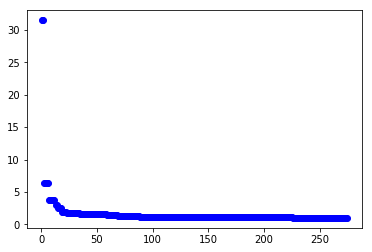

In [10]:
for i, row in enumerate(all_rsme_values,1):
    rsme_min = min(row)
    rsme_stdev = np.std(row)
    rsme_mean = np.mean(row)
    _ = plt.plot(i, rsme_min, 'bo')

## Test refactored version

In [11]:
from solvers.ea_solver import EASolver

In [12]:
solver = EASolver(X, pure_components, quadratic_correction)
solution, parameters = solver.solve(signal)

INFO:solvers.base_solver:Solution updated: Round 0, RSME 219.0718716760168
INFO:solvers.base_solver:Solution updated: Round 0, RSME 209.43003778608346
INFO:solvers.base_solver:Solution updated: Round 0, RSME 184.90631859994824
INFO:solvers.base_solver:Solution updated: Round 0, RSME 70.57948700301337
INFO:solvers.base_solver:Solution updated: Round 0, RSME 28.10948515831259
INFO:solvers.base_solver:Solution updated: Round 0, RSME 9.561466449775038
INFO:solvers.base_solver:Solution updated: Round 6, RSME 9.42913263579649
INFO:solvers.base_solver:Solution updated: Round 9, RSME 9.37131957390198
INFO:solvers.base_solver:Solution updated: Round 9, RSME 8.616206316728007
INFO:solvers.base_solver:Solution updated: Round 10, RSME 8.540209433000802
INFO:solvers.base_solver:Solution updated: Round 10, RSME 8.480997630393022
INFO:solvers.base_solver:Solution updated: Round 11, RSME 8.260821897059644
INFO:solvers.base_solver:Solution updated: Round 13, RSME 8.184176301801772
INFO:solvers.base_sol